# 誤差逆伝搬法

In [1]:
import sys, os
sys.path.append('deep-learning-from-scratch')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline

## レイヤの実装

レイヤは順伝搬のforward() と逆伝搬のbackward()を実装する。

### 乗算レイヤの実装

In [2]:
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None
        
    def forward(self, x, y):
        self.x = x
        self.y = y
        return x * y
        
        
    def backward(self, dout):
        """
        dout: 上流から伝わってきた微分
        """
        dx = dout * self.y
        dy = dout * self.x        
        return dx, dy
        

In [3]:
apple = 100
apple_num = 2
tax = 1.1

mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)
print(price)

220.00000000000003


In [4]:
dprice = 1
d_apple_price, d_tax = mul_tax_layer.backward(dprice)
d_apple, d_apple_num = mul_apple_layer.backward(d_apple_price)
print("Apple:", d_apple, "AppleNum:", d_apple_num, "Tax: ", d_tax)

Apple: 2.2 AppleNum: 110.00000000000001 Tax:  200


In [5]:
class AddLayer:
    def __init__(self):
        pass
        
    def forward(self, x, y):
        return x + y
        
    def backward(self, dout):
        """
        dout: 上流から伝わってきた微分
        """
        dx = dout * 1
        dy = dout * 1
        return dx, dy
        

In [6]:
# りんご２つ　と　みかん３つ　の買い物
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# layer
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)  # (1)
orange_price = mul_orange_layer.forward(orange, orange_num)  # (2)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)  # (3)
price = mul_tax_layer.forward(all_price, tax)  # (4)

# backward
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)  # (4)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)  # (3)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)  # (2)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)  # (1)

print("price:", int(price))
print("dApple:", dapple)
print("dApple_num:", int(dapple_num))
print("dOrange:", dorange)
print("dOrange_num:", int(dorange_num))
print("dTax:", dtax)


price: 715
dApple: 2.2
dApple_num: 110
dOrange: 3.3000000000000003
dOrange_num: 165
dTax: 650


In [7]:
class ReLU:
    def __init__(self):
        self.mask = None
        
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self_mask] = 0
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        return dx

In [8]:
class Sigmoid:
    def __init__(self):
        self.out = None
        
    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out
    
    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx

In [9]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
    
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW =  np.dot(self.x.T, dout)
        self.db = cp.sum(dout, axis = 0)
        return self.dx

In [10]:
from common.functions import cross_entropy_error, softmax
class softmaxWthLoss:
    def __init__(self):
        self.loss =None
        self.y = None
        self.t = None
    
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size

        return dx


## 誤差逆伝搬法の実装

ニューラルネットワーク学習の全体図

In [11]:
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # Weight / Bias 初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        """各レイヤへ伝搬"""
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # x:入力データ, t:教師データ
    def loss(self, x, t):
        """損失関数"""
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:入力データ, t:教師データ
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        """重みパラメータに対する勾配を誤差逆伝搬法によって求める"""
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

In [12]:
from dataset.mnist import load_mnist
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)
n = 3
x_batch = x_train[:n]
t_batch = t_train[:n]
grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)
# 各重みの絶対誤差の平均を求める
for key in grad_numerical.keys():
    diff = np.average( np.abs(grad_backprop[key] - grad_numerical[key]) ) 
    print(key + ":" + str(diff))

W1:2.66482928601e-13
b1:8.52096255968e-13
W2:8.83539676656e-13
b2:1.19904083884e-10


## 誤差逆伝搬法を使った学習

誤差逆伝搬を使うことによって、効率よく勾配を求めることができる。  
※4章でnumerical_gradientはおそすぎて話にならなかった・・・

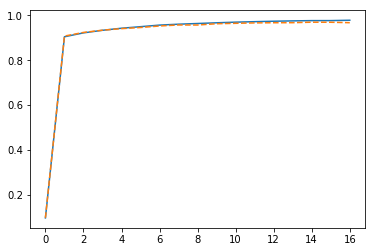

In [13]:
# CopyFrom 4

"""
ハイパーパラメータ
"""
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1


train_loss_list = []
train_acc_list = []
test_acc_list=[]
# 1エポックあたりの　繰り返しの数
iter_per_epoch = max(train_size / batch_size, 1)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num): # ミニバッチの取得

    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 勾配の計算
    grad = network.gradient(x_batch, t_batch)
    
    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
            network.params[key] -= learning_rate * grad[key]
            
    # 学習経過の記録
    loss = network.loss(x_batch, t_batch) 
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train) # 訓練データ自体の認識精度
        test_acc = network.accuracy(x_test, t_test) # テストデータの認識精度
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

plt.plot(train_acc_list)
plt.plot(test_acc_list, linestyle='--')